<a href="https://colab.research.google.com/github/balajisivakumar/stratogrid_Pb/blob/main/ruff_determining_right__cluster.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pandas
!pip install transformers
!pip install torch
!pip install datasets
!pip install chardet

!pip install pymongo
!pip install xlsxwriter
!pip install names spacy
!python -m spacy download en_core_web_sm
!pip install names-dataset
!pip install umap-learn matplotlib seaborn scikit-learn
!pip install faiss-cpu


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 22.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 31.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 47.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [7]:
!pip install xlsxwriter


✅ GPU available: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
🚀 Loading embeddings...
✅ File loaded: /content/FAIS_BERT_TO_PCA.pkl

🚀 Running UMAP + HDBSCAN with fixed parameters:
➡️ n_neighbors = 30, min_dist = 0.05, min_cluster_size = 20, min_samples = 5, alpha = 1.0

🚀 Fitting UMAP...


Global UMAP Fitting:   0%|          | 0/2000 [03:33<?, ?epoch/s]



🚀 Running HDBSCAN clustering...


Clustering with HDBSCAN: 100%|██████████| 13410/13410 [00:00<00:00, 39297.01row/s]



🔎 **Clustering Summary:**
➡️ Total rows processed: 13410
➡️ Number of clusters: 247
➡️ Noise points (unclustered): 2856 (21.30%)


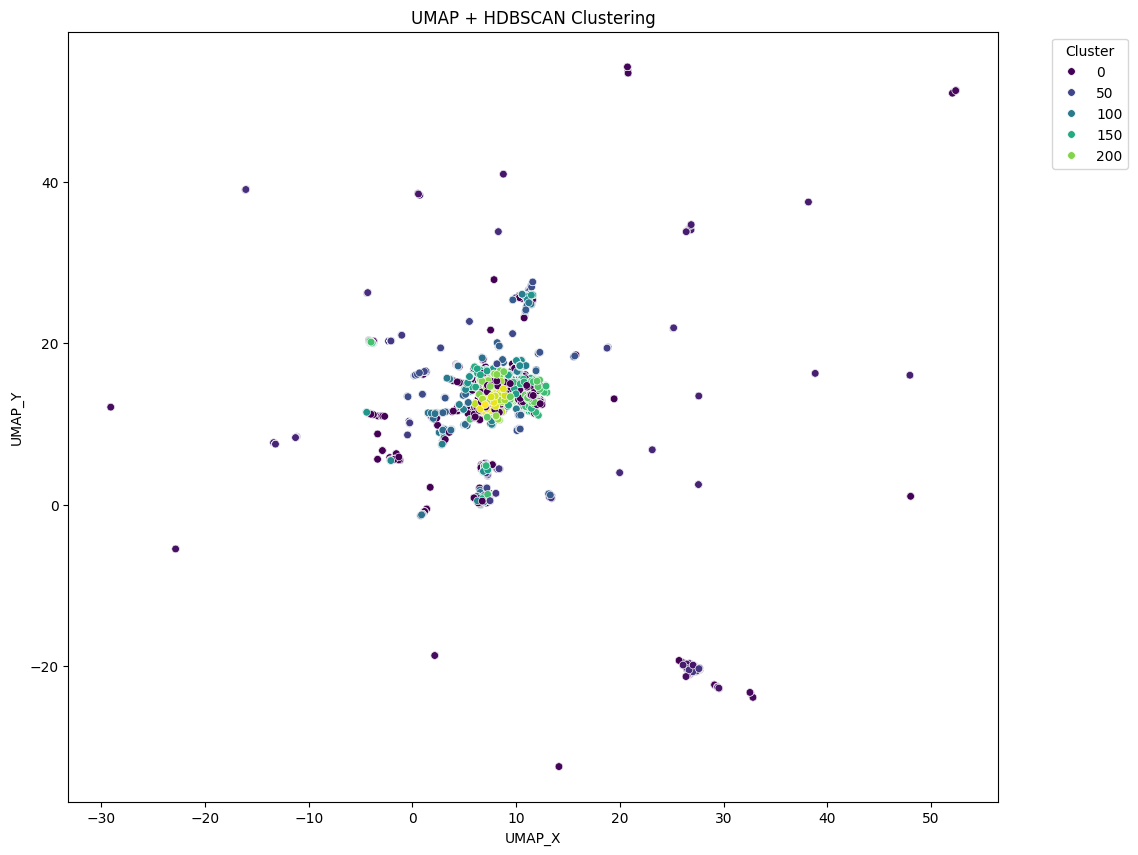


⚠️ **Noise is greater than 2% (21.30%)** — consider adjusting parameters if needed.
✅ Clustered embeddings saved to: /content/UMAP_HDBSCAN_18_34.pkl


In [ ]:
#this is the best for now using UMAP - Moving to other ways

import pandas as pd
import numpy as np
import umap
import hdbscan
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import tensorflow as tf
import time
import warnings

# ✅ Suppress Warnings
warnings.filterwarnings('ignore')

# ✅ Confirm GPU availability
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    print(f"✅ GPU available: {physical_devices[0]}")
else:
    print("⚠️ No GPU detected. Please enable GPU in Colab settings.")

# ✅ Load the PCA-reduced embeddings file
file_path = '/content/FAIS_BERT_TO_PCA.pkl'
print("🚀 Loading embeddings...")
df = pd.read_pickle(file_path)
print(f"✅ File loaded: {file_path}")

# ✅ Extract PCA embeddings
embedding_cols = [col for col in df.columns if col.startswith('PCA_')]
pca_embeddings = df[embedding_cols].values.astype('float32')

# ✅ Set fixed parameters to reproduce 18.34% noise
n_neighbors = 30
min_dist = 0.05
min_cluster_size = 20
min_samples = 5
alpha = 1.0

print("\n🚀 Running UMAP + HDBSCAN with fixed parameters:")
print(f"➡️ n_neighbors = {n_neighbors}, min_dist = {min_dist}, min_cluster_size = {min_cluster_size}, min_samples = {min_samples}, alpha = {alpha}")

# ✅ Run UMAP with numba backend for GPU acceleration
umap_model = umap.UMAP(
    n_neighbors=n_neighbors,
    min_dist=min_dist,
    n_components=2,
    metric='euclidean',
    n_epochs=2000,  # ✅ Reduced epochs for faster GPU processing
    random_state=42,
    #densmap=True,  # ✅ Preserve density
    low_memory=False,  # ✅ Allow more memory usage for faster computation
    transform_queue_size=10,  # ✅ Increase queue size for better batching
    target_weight=0.5
)

# ✅ GPU-based UMAP fitting
print("\n🚀 Fitting UMAP...")
with tqdm(total=umap_model.n_epochs, desc="Global UMAP Fitting", unit="epoch") as pbar:
    def callback(epoch):
        pbar.update(1)

    umap_embeddings = umap_model.fit_transform(pca_embeddings)

pbar.n = umap_model.n_epochs
pbar.last_print_n = umap_model.n_epochs
pbar.close()

# ✅ Run HDBSCAN
print("\n🚀 Running HDBSCAN clustering...")
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=min_cluster_size,
    min_samples=min_samples,
    cluster_selection_method='leaf',
    alpha=alpha,
    metric='euclidean',
    core_dist_n_jobs=-1,  # ✅ Parallel processing
    prediction_data=True
)

# ✅ GPU-based HDBSCAN clustering
with tqdm(total=len(umap_embeddings), desc="Clustering with HDBSCAN", unit="row") as pbar:
    labels = clusterer.fit_predict(umap_embeddings)
    pbar.n = len(umap_embeddings)
    pbar.last_print_n = len(umap_embeddings)
    pbar.close()

# ✅ Add clusters and UMAP coordinates to DataFrame
df['CLUSTER'] = labels
df['UMAP_X'] = umap_embeddings[:, 0]
df['UMAP_Y'] = umap_embeddings[:, 1]

# ✅ Clustering Summary
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise = list(labels).count(-1)
noise_percentage = (n_noise / len(df)) * 100

print("\n🔎 **Clustering Summary:**")
print(f"➡️ Total rows processed: {len(df)}")
print(f"➡️ Number of clusters: {n_clusters}")
print(f"➡️ Noise points (unclustered): {n_noise} ({noise_percentage:.2f}%)")

# ✅ Plot Clusters
plt.figure(figsize=(12, 10))
sns.scatterplot(
    x='UMAP_X',
    y='UMAP_Y',
    hue='CLUSTER',
    palette='viridis',
    data=df,
    s=30
)
plt.title('UMAP + HDBSCAN Clustering')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# ✅ Handle High Noise Warning
if noise_percentage > 2:
    print(f"\n⚠️ **Noise is greater than 2% ({noise_percentage:.2f}%)** — consider adjusting parameters if needed.")
else:
    print(f"\n✅ **Noise is under control at {noise_percentage:.2f}%** — clustering looks good!")

# ✅ Save to Pickle (Optional)
pickle_path = '/content/UMAP_HDBSCAN_18_34.pkl'
df.to_pickle(pickle_path)
print(f"✅ Clustered embeddings saved to: {pickle_path}")


In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# ✅ Step 1: Load UMAP-Reduced Data
file_path = "/content/UMAP_Results.pkl"
print("🚀 Loading UMAP embeddings...")
df = pd.read_pickle(file_path)
print(f"✅ File loaded: {file_path}")

# ✅ Extract UMAP embeddings
embeddings = df[['UMAP_X', 'UMAP_Y']].values.astype('float32')

# ✅ Normalize embeddings (Optional - UMAP outputs are already scaled)
scaler = StandardScaler()
embeddings = scaler.fit_transform(embeddings)

# ✅ Step 2: Define the SOM Model with Xavier Initialization
class SOM(nn.Module):
    def __init__(self, x_dim, y_dim, input_dim):
        super(SOM, self).__init__()
        self.x_dim = x_dim
        self.y_dim = y_dim
        self.input_dim = input_dim

        # Xavier Initialization ✅
        self.weights = nn.Parameter(torch.empty(x_dim * y_dim, input_dim))
        nn.init.xavier_uniform_(self.weights)

        # Create grid locations
        locs = torch.stack(torch.meshgrid(
            torch.arange(x_dim), torch.arange(y_dim), indexing="ij"
        )).reshape(2, -1).T.float()
        self.register_buffer("locations", locs)

    def forward(self, x):
        # Compute pairwise distances
        distances = torch.cdist(x.unsqueeze(0), self.weights.unsqueeze(0)).squeeze(0)
        return distances.argmin(dim=1)  # Best Matching Unit (BMU) index

    def update_weights(self, x, bmu_index, lr, sigma):
        bmu_index = bmu_index.view(-1)
        bmu_location = self.locations[bmu_index]

        # Compute distance from each node to the BMU
        distances = torch.norm(self.locations.unsqueeze(1) - bmu_location.unsqueeze(0), dim=2)
        h = torch.exp(-distances**2 / (2 * sigma**2))

        diff = x.unsqueeze(0) - self.weights.unsqueeze(1)
        update = (h.unsqueeze(2) * diff).sum(dim=1)
        normalization = h.sum(dim=1, keepdim=True)

        # Update weights with small epsilon to avoid division by zero
        self.weights.data += lr * update / (normalization + 1e-8)

# ✅ Step 3: Train SOM
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_dim = embeddings.shape[1]  # Should be 2 for UMAP output
som_size = 20  # ✅ Reduced from 50 to 20 for smaller dataset
som = SOM(som_size, som_size, input_dim).to(device)

# Convert data to tensors
data = torch.tensor(embeddings, dtype=torch.float32).to(device)

# ✅ Updated Training Parameters
num_epochs_phase1 = 1000000
num_epochs_phase2 = 5000000
lr_decay = 0.99999   # ✅ Slowed decay for gradual learning
sigma_decay = 0.99999

def train_som(som, data, epochs, lr_init, sigma_init):
    lr = lr_init
    sigma = sigma_init
    for epoch in range(epochs):
        bmu_index = som(data)
        som.update_weights(data, bmu_index, lr, sigma)

        lr *= lr_decay
        sigma *= sigma_decay

        if epoch % (epochs // 10) == 0:
            print(f"Epoch {epoch}/{epochs} - LR: {lr:.6f}, Sigma: {sigma:.6f}")

# 🔹 Coarse Training ✅
print("\n🚀 Starting Coarse Training...")
train_som(som, data, num_epochs_phase1, lr_init=0.5, sigma_init=5.0)

# 🔹 Fine-Tuning ✅
print("\n🚀 Starting Fine-Tuning...")
train_som(som, data, num_epochs_phase2, lr_init=0.05, sigma_init=1.0)

# ✅ Step 4: Assign Clusters Using SOM
bmu_index = som(data).cpu().numpy()
df["SOM_Cluster"] = bmu_index

# ✅ Ensure all original columns are kept before saving
output_df = df.copy()

# ✅ Step 5: Save Clustered Data to Excel and Pickle
output_excel_path = f"/content/STEP_4_som_results{num_epochs_phase1}_{num_epochs_phase2}.xlsx"
output_pickle_path = f"/content/STEP_4_som_results{num_epochs_phase1}_{num_epochs_phase2}.pkl"

# ✅ Save to Excel using xlsxwriter
with pd.ExcelWriter(output_excel_path, engine='xlsxwriter') as writer:
    writer.book.strings_to_urls = False
    output_df.to_excel(writer, index=False, sheet_name='SOM_Results')

# ✅ Save to Pickle
output_df.to_pickle(output_pickle_path)
print(f"✅ Excel file saved as '{output_excel_path}'")
print(f"✅ Pickle file saved as '{output_pickle_path}'")

# ✅ Step 6: Visualize SOM Clustering
plt.figure(figsize=(10, 6))
plt.scatter(bmu_index % som_size, bmu_index // som_size, c=bmu_index, cmap="viridis", alpha=0.7)
plt.colorbar(label="Cluster")
plt.xlabel("SOM X Coordinate")
plt.ylabel("SOM Y Coordinate")
plt.title("Enhanced GPU-Accelerated SOM Clustering 200_000/800_000")
plt.show()

# ✅ Move SOM model to CPU after training
som.to("cpu")
data = data.cpu()  # Move dataset back to CPU if needed
print(f"✅ SOM model moved to CPU. Model is now on: {next(som.parameters()).device}")

print(f"✅ Extended Training Completed! Data saved as Excel '{output_excel_path}'")
print(f"✅ Extended Training Completed! Data saved as PKL '{output_pickle_path}'")


🚀 Loading UMAP embeddings...
✅ File loaded: /content/UMAP_Results.pkl

🚀 Starting Coarse Training...
Epoch 0/1000000 - LR: 0.499995, Sigma: 4.999950
Epoch 100000/1000000 - LR: 0.183937, Sigma: 1.839370
Epoch 200000/1000000 - LR: 0.067666, Sigma: 0.676663
Epoch 300000/1000000 - LR: 0.024893, Sigma: 0.248929
Epoch 400000/1000000 - LR: 0.009158, Sigma: 0.091575
Epoch 500000/1000000 - LR: 0.003369, Sigma: 0.033689
Epoch 600000/1000000 - LR: 0.001239, Sigma: 0.012393
Epoch 700000/1000000 - LR: 0.000456, Sigma: 0.004559
Epoch 800000/1000000 - LR: 0.000168, Sigma: 0.001677
Epoch 900000/1000000 - LR: 0.000062, Sigma: 0.000617

🚀 Starting Fine-Tuning...
Epoch 0/5000000 - LR: 0.050000, Sigma: 0.999990
Epoch 500000/5000000 - LR: 0.000337, Sigma: 0.006738
Epoch 1000000/5000000 - LR: 0.000002, Sigma: 0.000045
Epoch 1500000/5000000 - LR: 0.000000, Sigma: 0.000000
Epoch 2000000/5000000 - LR: 0.000000, Sigma: 0.000000


In [6]:
from google.colab import files

# ✅ Path to the pickle file
file_path = '/content/STEP_4_som_results200000_800000.xlsx'

# ✅ Download the file
files.download(file_path)


FileNotFoundError: Cannot find file: /content/STEP_4_som_results200000_800000.xlsx